In [7]:
from diffusion_curvature.datasets import torus
import graphtools
import matplotlib.pyplot as plt
import numpy as np
import torch
import pygsp
from tqdm import tqdm
from sklearn.neighbors import KernelDensity
from scipy import stats

#from diffusion_curvature.core import DiffusionCurvature
from fastcore.all import *
from nbdev.showdoc import *
import diffusion_curvature
from diffusion_curvature.graphs import *
from diffusion_curvature.datasets import *
from diffusion_curvature.core import *
from diffusion_curvature.utils import *
from diffusion_curvature.comparison_space import *
from diffusion_curvature.sadspheres import *
from diffusion_curvature.kernels import *




In [8]:
X_torus, torus_gaussian_curvature = torus(n=5000)
G_torus = graphtools.Graph(X_torus, anisotropy=1, knn=30)

In [9]:
def fixed_graph_former(X, sigma, alpha):
    W = gaussian_kernel(
        X, 
        kernel_type = "fixed",
        sigma = sigma,
        anisotropic_density_normalization = alpha,
    )
    # set diagonal of W to zero
    np.fill_diagonal(W, 0)
    G = pygsp.graphs.Graph(W)
    return G

In [10]:

DC = DiffusionCurvature()


sigma = 0.2
alpha = 1

graph_former = partial(fixed_graph_former, sigma = sigma, alpha = alpha)
G = graph_former(X_torus)

In [11]:
torus_gaussian_curvature.shape

(5000,)

In [12]:
X_torus.shape

(5000, 3)

In [13]:
ks = DC.unsigned_curvature(G, t=25)

2024-05-08 16:39:01.837791: W external/xla/xla/service/gpu/nvptx_compiler.cc:718] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.4.131). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


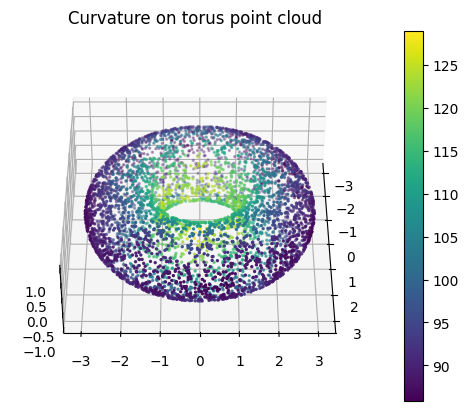

In [14]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(X_torus[:, 0], X_torus[:, 1], X_torus[:, 2], s=2, c = ks)
ax.set_title("Curvature on torus point cloud")
ax.view_init(40, 0)
plt.colorbar(scatter)
ax.set_aspect('equal')
plt.show()

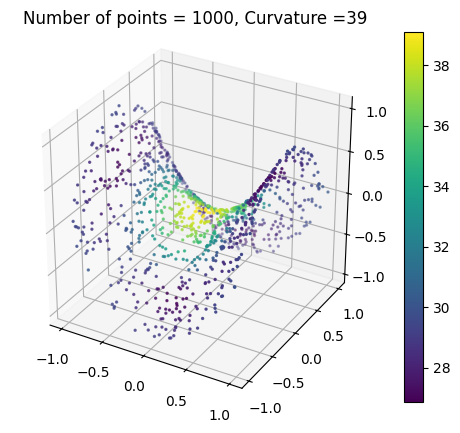

In [15]:
graph_former = partial(fixed_graph_former, sigma = 0.18, alpha = 1)
X_saddle, ks_saddle = rejection_sample_from_saddle(1000, 2)
G = graph_former(X_saddle)
ks = DC.unsigned_curvature(G, t=25)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(X_saddle[:, 0], X_saddle[:, 1], X_saddle[:, 2], s=2, c = ks)
ax.set_title("Number of points = 1000, Curvature =%d" % ks[0])
#ax.view_init(40, 0)
plt.colorbar(scatter)
ax.set_aspect('equal')
plt.show()

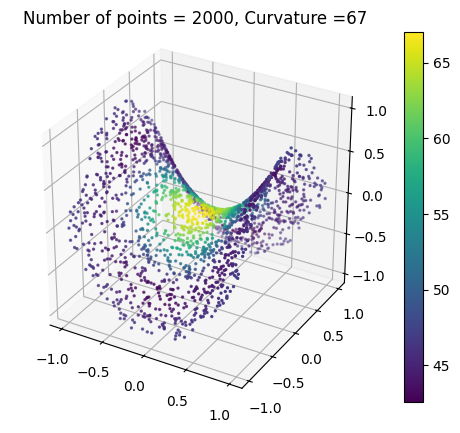

In [16]:
graph_former = partial(fixed_graph_former, sigma = 0.18, alpha = 1)
X_saddle, ks_saddle = rejection_sample_from_saddle(2000, 2)
G = graph_former(X_saddle)
ks = DC.unsigned_curvature(G, t=25)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(X_saddle[:, 0], X_saddle[:, 1], X_saddle[:, 2], s=2, c = ks)
ax.set_title("Number of points = 2000, Curvature =%d" % ks[0])
#ax.view_init(40, 0)
plt.colorbar(scatter)
ax.set_aspect('equal')
plt.show()

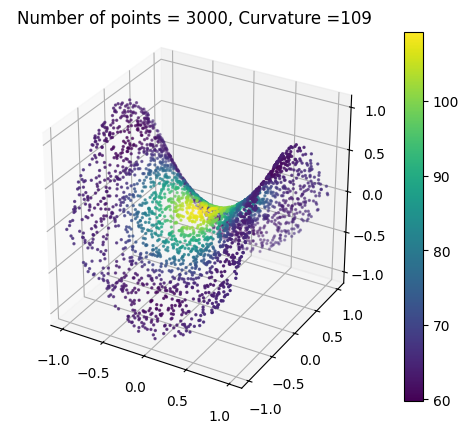

In [17]:
graph_former = partial(fixed_graph_former, sigma = 0.18, alpha = 1)
X_saddle, ks_saddle = rejection_sample_from_saddle(3000, 2)
G = graph_former(X_saddle)
ks = DC.unsigned_curvature(G, t=25)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(X_saddle[:, 0], X_saddle[:, 1], X_saddle[:, 2], s=2, c = ks)
ax.set_title("Number of points = 3000, Curvature =%d" % ks[0])
#ax.view_init(40, 0)
plt.colorbar(scatter)
ax.set_aspect('equal')
plt.show()

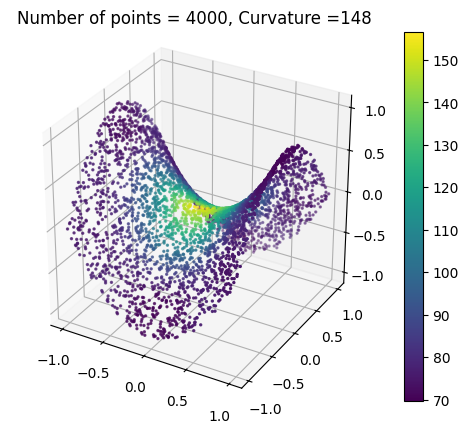

148.79663


In [18]:
graph_former = partial(fixed_graph_former, sigma = 0.18, alpha = 1)

X_saddle, ks_saddle = rejection_sample_from_saddle(4000, 2)
G = graph_former(X_saddle)
ks = DC.unsigned_curvature(G, t=25)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(X_saddle[:, 0], X_saddle[:, 1], X_saddle[:, 2], s=2, c = ks)
ax.set_title("Number of points = 4000, Curvature =%d" % ks[0])
#ax.view_init(40, 0)
plt.colorbar(scatter)
ax.set_aspect('equal')
plt.show()
print(ks[0])

In [77]:
graph_former = partial(fixed_graph_former, sigma = 0.18, alpha = 1)
t = np.linspace(500, 4000, num=4001-500, dtype=int)

cur = []
for k in tqdm(t):
    X_saddle, ks_saddle = rejection_sample_from_saddle(k, 2)
    G = graph_former(X_saddle)
    ks = DC.unsigned_curvature(G, t=25)
    cur.append(ks[0])

100%|██████████| 3501/3501 [1:57:48<00:00,  2.02s/it]


In [22]:
t = np.linspace(500, 4000, num=4001-500, dtype=int)
den = []
for k in tqdm(t):
    X_saddle, ks_saddle = rejection_sample_from_saddle(k, 2)
    values = X_saddle.T
    kde = stats.gaussian_kde(values)
    density = kde(values)[0]

    den.append(density)

100%|██████████| 3501/3501 [05:40<00:00, 10.28it/s]


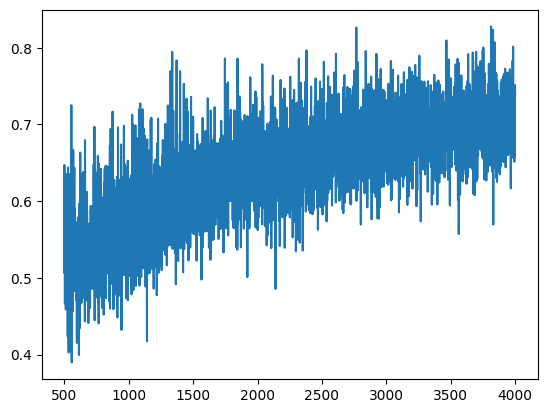

In [23]:
plt.plot(t, den, label = 'Diffusion curvature')

In [24]:
from sklearn.metrics import pairwise_distances
def gaussian_kernel(
        X:np.ndarray, # pointcloud data as rows, shape n x d
        kernel_type = "fixed", # either fixed, or adaptive
        sigma:float = 0, # if fixed, uses kernel bandwidth sigma. If not set, uses a heuristic to estimate a good sigma value
        k:float = 10, # if adaptive, creates a different kernel bandwidth for each point, based on the distance from that point to the kth nearest neighbor
        anisotropic_density_normalization:float = 0.5, # if nonzero, performs anisotropic density normalization
        threshold_for_small_values:float = 1e-5, # Sets all affinities below this value to zero. Set to zero to disable.
        neighbor_scale:float = 3.0, # if curvature agnostic, this is the scale of the neighbor distance
):
    """Constructs an affinity matrix from pointcloud data, using a gaussian kernel"""
    supported_kernel_types = {'fixed', 'adaptive', 'curvature agnostic'}
    assert kernel_type in supported_kernel_types
    D = pairwise_distances(X)
    if kernel_type == "fixed":
        if not sigma:
            # estimate sigma using a heuristic
            sigma = median_heuristic(D)
        W = (1/(sigma*np.sqrt(2*np.pi)))*np.exp((-D**2)/(2*sigma**2))
    elif kernel_type == "adaptive":
        distance_to_k_neighbor = np.partition(D,k)[:,k]
        # Populate matrices with this distance for easy division.
        div1 = np.ones(len(D))[:,None] @ distance_to_k_neighbor[None,:]
        div2 = distance_to_k_neighbor[:,None] @ np.ones(len(D))[None,:]
        # print("Distance to kth neighbors",distance_to_k_neighbor)
        # compute the gaussian kernel with an adaptive bandwidth
        W = (1/(2*np.sqrt(2*np.pi)))*(np.exp(-D**2/(2*div1**2))/div1 + np.exp(-D**2/(2*div2**2))/div2)
    elif kernel_type == "curvature agnostic":
        scaled_neighbor_dists = np.partition(D,k)[:,:k] * neighbor_scale # TODO is multiplication best here?
        sigma = np.mean(scaled_neighbor_dists)
        W = np.exp((-D**2)/sigma**2)
        # div1 = np.ones(len(D))[:,None] @ scaled_neighbor_dists[None,:]
        # div2 = scaled_neighbor_dists[:,None] @ np.ones(len(D))[None,:]
        # W = (1/(2*np.sqrt(2*np.pi)))*(np.exp(-D**2/(2*div1**2))/div1 + np.exp(-D**2/(2*div2**2))/div2)
    if anisotropic_density_normalization:
        D = np.diag(1/(np.sum(W,axis=1)**anisotropic_density_normalization))
        W = D @ W @ D
    if threshold_for_small_values:
        W[W < threshold_for_small_values] = 0
    return W

def get_curvature_agnostic_graph(X, neighbor_scale = 1, k = 1, alpha = 1):
    W = gaussian_kernel(
        X, 
        kernel_type = "curvature agnostic", 
        k = k, 
        neighbor_scale=neighbor_scale, 
        anisotropic_density_normalization = alpha)
    # set diagonal of W to zero
    np.fill_diagonal(W, 0)
    G = pygsp.graphs.Graph(W)
    return G

In [ ]:
DC = DiffusionCurvature()
graph_former = partial(get_curvature_agnostic_graph, neighbor_scale = 1, k = 100, alpha = 1)
t = np.linspace(500, 4000, num=4001-500, dtype=int)

cur = []
for k in tqdm(t):
    X_saddle, ks_saddle = rejection_sample_from_saddle(k, 2)
    G = graph_former(X_saddle)
    ks = DC.unsigned_curvature(G, t=25)
    cur.append(ks[0])

In [26]:
cur = np.load('diff_cur.npy')
t = np.linspace(500, 4000, num=4001-500, dtype=int)

In [44]:
slope

0.03602239891030881

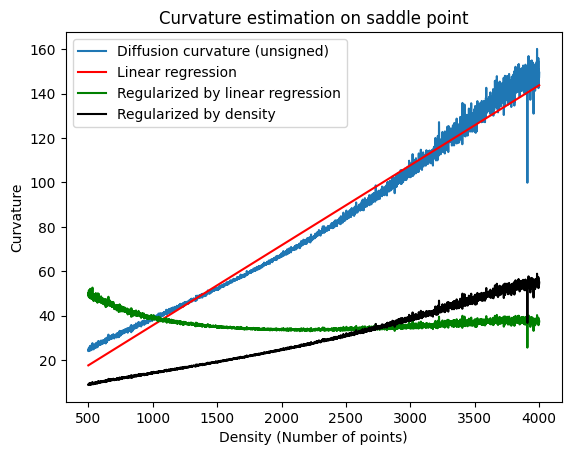

In [46]:
slope, intercept = np.polyfit(t, cur, 1)
plt.plot(t, cur, label = 'Diffusion curvature (unsigned)')

plt.plot(t, slope*t + intercept, color='red', label='Linear regression')
plt.plot(t, (cur - intercept)/t * 1000, color='green', label='Regularized by linear regression')
plt.plot(t, cur/np.exp(np.array(den)**0.001), color='black', label='Regularized by density')
plt.xlabel('Density (Number of points)')
plt.ylabel('Curvature')
plt.title('Curvature estimation on saddle point')
plt.legend()
plt.show()

## Use PCA comparison space 

In [39]:
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors

In [118]:
def sample_locally(X, query, use_radius = False, num_points = 500, radius = 0.5):
    if use_radius: 
        k = int(len(X)*0.5)
        nbrs =NearestNeighbors(n_neighbors=k, algorithm='ball_tree').fit(X)
        idx = nbrs.radius_neighbors(query, radius, sort_results = True)[1][0]
    else:
        nbrs =NearestNeighbors(n_neighbors=num_points, algorithm='ball_tree').fit(X)
        idx = nbrs.kneighbors(query, num_points, return_distance=False)
    return X[idx].squeeze()

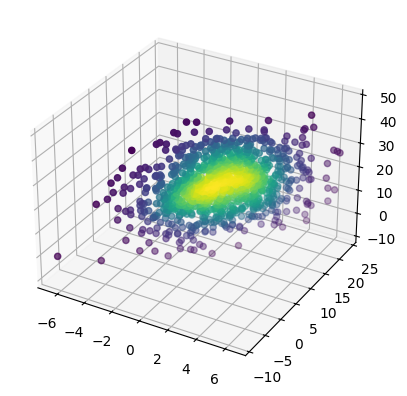

In [171]:
mu=np.array([1,10,20])
sigma=np.matrix([[4,10,0],[10,25,0],[0,0,100]])
data=np.random.multivariate_normal(mu,sigma,1000)
values = data.T

kde = stats.gaussian_kde(values)
density = kde(values)

fig, ax = plt.subplots(subplot_kw=dict(projection='3d'))
x, y, z = values
ax.scatter(x, y, z, c=density)
plt.show()

In [172]:
values.shape

(3, 1000)

In [132]:
use_radius = False
X_saddle, ks_saddle = rejection_sample_from_saddle(2000, 2)
X_sub = sample_locally(X_saddle, X_saddle[0].reshape(1, -1), use_radius = use_radius, num_points = 500, radius = 0.5)


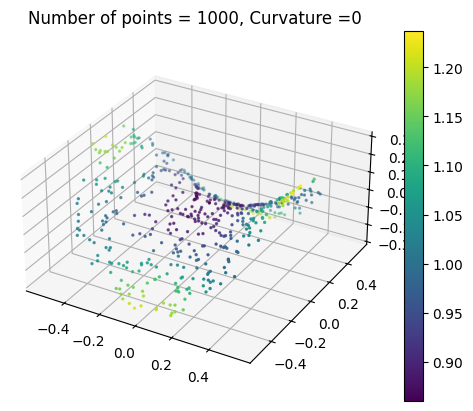

In [133]:
graph_former = partial(fixed_graph_former, sigma = 0.18, alpha = 1)
pca = PCA(n_components=2).fit(X_sub)
Y = pca.transform(X_sub)
G = graph_former(X_sub)
G_flat = graph_former(Y)
ks = DC.unsigned_curvature(G, t=25)
ks_flat = DC.unsigned_curvature(G_flat, t=25)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(X_sub[:, 0], X_sub[:, 1], X_sub[:, 2], s=2, c = ks - ks_flat)
ax.set_title("Number of points = 1000, Curvature =%d" % (ks - ks_flat)[0])
#ax.view_init(40, 0)
plt.colorbar(scatter)
ax.set_aspect('equal')
plt.show()

## On sphere

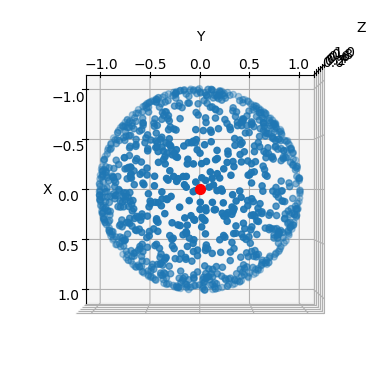

In [231]:
import numpy as np

def sample_hemisphere(num_points, r = 1):
    # Generate random angles for spherical coordinates
    phi = np.random.uniform(0, 2*np.pi, num_points)  # azimuthal angle
    theta = np.arccos(np.linspace(1, 0, num_points))  # polar angle

    # Convert spherical coordinates to Cartesian coordinates
    x = r * np.sin(theta) * np.cos(phi)
    y = r * np.sin(theta) * np.sin(phi)
    z = r * np.cos(theta)

    # Combine x, y, and z coordinates into a (num_points, 3) array
    points = np.stack((x, y, z), axis=1)

    return points

num_points = 1000
points_on_sphere = sample_hemisphere(num_points)

# Plot the sampled points in 3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(points_on_sphere[:, 0], points_on_sphere[:, 1], points_on_sphere[:, 2])
ax.scatter(points_on_sphere[0, 0], points_on_sphere[0, 1], points_on_sphere[0, 2], s =50, c = 'red')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.view_init(90, 0)
plt.show()


In [232]:
DC = DiffusionCurvature()

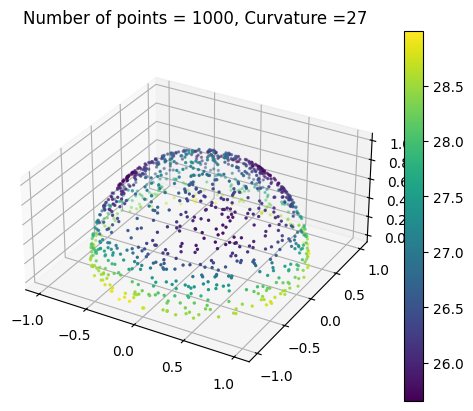

In [233]:
graph_former = partial(fixed_graph_former, sigma = 0.18, alpha = 1)
X_sphere = sample_hemisphere(1000)
G = graph_former(X_sphere)
ks = DC.unsigned_curvature(G, t=25)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(X_sphere[:, 0], X_sphere[:, 1], X_sphere[:, 2], s=2, c = ks)
ax.set_title("Number of points = 1000, Curvature =%d" % ks[0])
#ax.view_init(40, 0)
plt.colorbar(scatter)
ax.set_aspect('equal')
plt.show()

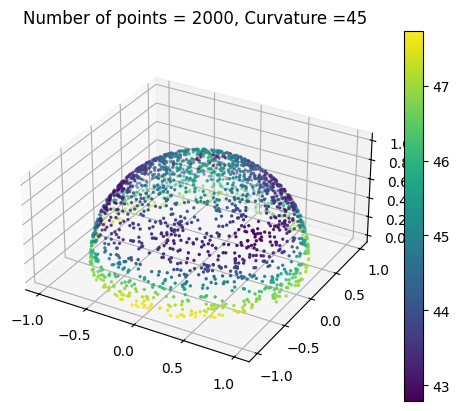

In [235]:
graph_former = partial(fixed_graph_former, sigma = 0.18, alpha = 1)
X_sphere = sample_hemisphere(2000)
G = graph_former(X_sphere)
ks = DC.unsigned_curvature(G, t=25)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(X_sphere[:, 0], X_sphere[:, 1], X_sphere[:, 2], s=2, c = ks)
ax.set_title("Number of points = 2000, Curvature =%d" % ks[0])
#ax.view_init(40, 0)
plt.colorbar(scatter)
ax.set_aspect('equal')
plt.show()

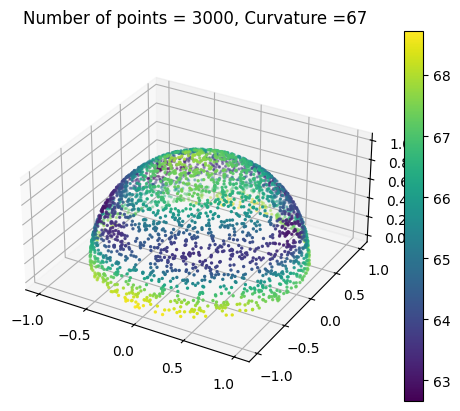

In [236]:
graph_former = partial(fixed_graph_former, sigma = 0.18, alpha = 1)
X_sphere = sample_hemisphere(3000)
G = graph_former(X_sphere)
ks = DC.unsigned_curvature(G, t=25)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(X_sphere[:, 0], X_sphere[:, 1], X_sphere[:, 2], s=2, c = ks)
ax.set_title("Number of points = 3000, Curvature =%d" % ks[0])
#ax.view_init(40, 0)
plt.colorbar(scatter)
ax.set_aspect('equal')
plt.show()

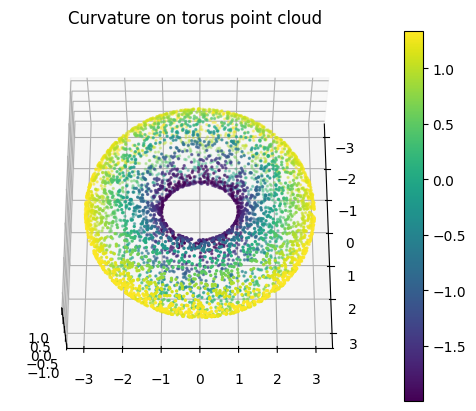

In [20]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(X_torus[:, 0], X_torus[:, 1], X_torus[:, 2], s=2, c = torus_gaussian_curvature)
ax.set_title("Curvature on torus point cloud")
ax.view_init(60, 0)
plt.colorbar(scatter)
ax.set_aspect('equal')
plt.show()

In [3]:
from diffusion_curvature.manifold_graph import ManifoldGraph, diffusion_curvature, diffusion_entropy_curvature, entropy_of_diffusion, wasserstein_spread_of_diffusion, power_diffusion_matrix, phate_distances
from diffusion_curvature.kernels import gaussian_kernel
import numpy as np

In [4]:
def generate_torus_point_cloud(num_points = 5000, R = 3, r = 1):
    # Generate random angles for theta and phi
    theta = np.random.uniform(0, 2*np.pi, num_points)
    phi = np.random.uniform(0, 2*np.pi, num_points)

    # Compute the torus points
    x = (R + r * np.cos(phi)) * np.cos(theta)
    y = (R + r * np.cos(phi)) * np.sin(theta)
    z = r * np.sin(phi)

    K = np.cos(phi)/(r * (R + r * np.cos(phi))) 

    return np.column_stack((x, y, z)), K

# Create torus parameters
R = 1 # Major radius
r = 0.375  # Minor radius
num_samples = 5000

# Generate a sphere point cloud with 1000 points and radius 1
X_torus, torus_K = generate_torus_point_cloud(num_points = num_samples, R = R, r = r)

In [5]:
A = gaussian_kernel(X_torus, kernel_type="adaptive", k = 20, anisotropic_density_normalization=1)
np.fill_diagonal(A,0)
# initialize the manifold graph; input your computed dimension along with the adjacency matrix
G_pure = ManifoldGraph(A = A, dimension=2, anisotropic_density_normalization=1)



In [6]:
G_pure = diffusion_curvature(G_pure, t=8)
ks_entropy = entropy_of_diffusion(G_pure)

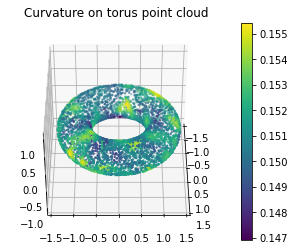

In [7]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(X_torus[:, 0], X_torus[:, 1], X_torus[:, 2], s=2, c = 1/ks_entropy)
ax.set_title("Curvature on torus point cloud")
ax.view_init(40, 0)
plt.colorbar(scatter)
ax.set_aspect('equal')
plt.show()

In [34]:
from scipy.stats import pearsonr

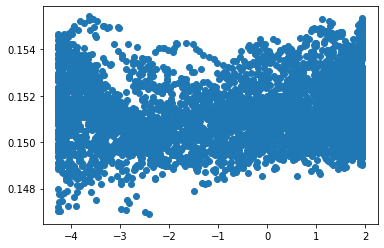

In [8]:
plt.scatter(torus_K, 1/ks_entropy)

In [ ]:
corr, _ = pearsonr(torus_K, G_pure.ks)
corr

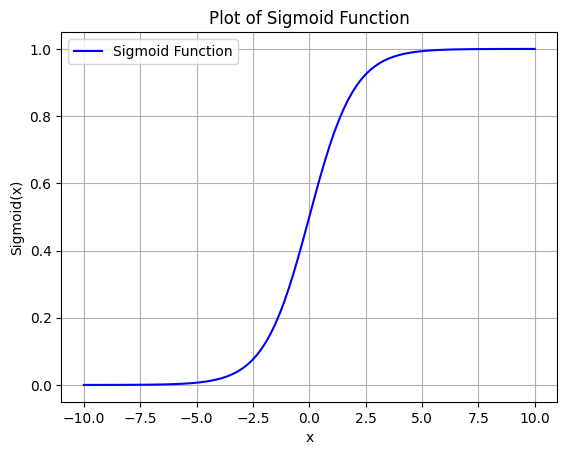

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Define the sigmoid function
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# Generate x values
x = np.linspace(-10, 10, 100)

# Compute y values using the sigmoid function
y = sigmoid(x)

# Plot the sigmoid function
plt.plot(x, y, label='Sigmoid Function', color='blue')
plt.xlabel('x')
plt.ylabel('Sigmoid(x)')
plt.title('Plot of Sigmoid Function')
plt.grid(True)
plt.legend()
plt.show()


$f(x ,y) = z$, then compose with a sigmoid $g(z) = \frac{1}{1+ e^{-z}}$